In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("DIABETES DETECTION SYSTEM")
print("Using SMOTE + RFE + 5-Fold Cross Validation")
print("="*80)

DIABETES DETECTION SYSTEM
Using SMOTE + RFE + 5-Fold Cross Validation


In [3]:
# ============================================================================
# 2. LOAD DATASET
# ============================================================================
print("\n[1] Loading Dataset...")
df = pd.read_csv('/content/sample_data/diabetes.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nDataset Info:")
print(df.info())

print(f"\nStatistical Summary:")
print(df.describe())

# Check class distribution
print(f"\nClass Distribution:")
print(df['Outcome'].value_counts())
print(f"Percentage: \n{df['Outcome'].value_counts(normalize=True) * 100}")


[1] Loading Dataset...
Dataset shape: (768, 9)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregna


[2] Performing Exploratory Data Analysis...


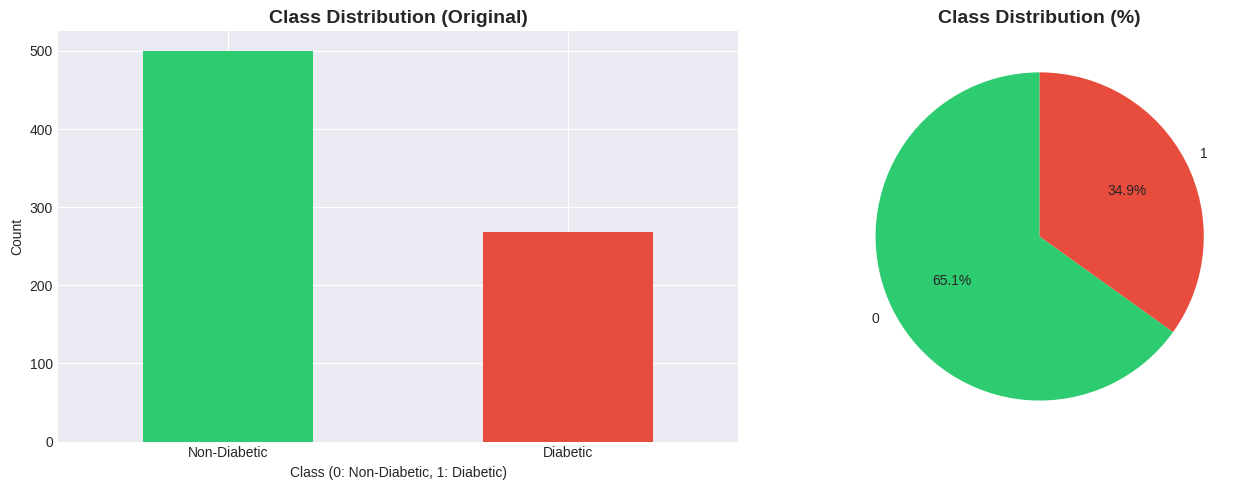

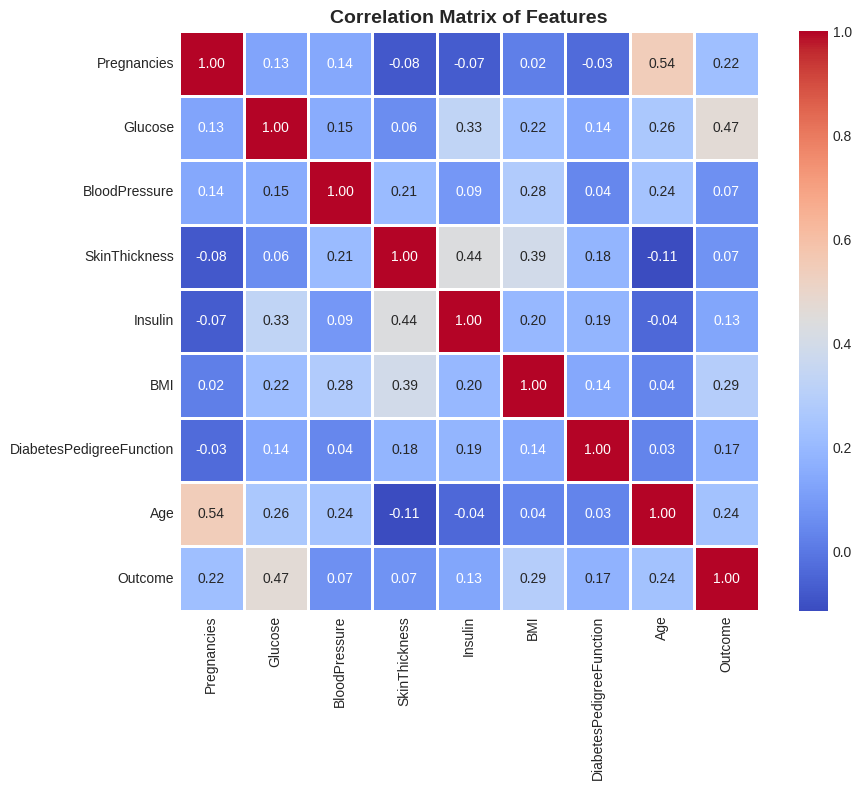

In [4]:
# ============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================
print("\n[2] Performing Exploratory Data Analysis...")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
df['Outcome'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (Original)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0: Non-Diabetic, 1: Diabetic)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Diabetic', 'Diabetic'], rotation=0)

# Percentage
df['Outcome'].value_counts(normalize=True).plot(kind='pie', ax=axes[1],
                                                 autopct='%1.1f%%',
                                                 colors=['#2ecc71', '#e74c3c'],
                                                 startangle=90)
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=1)
plt.title('Correlation Matrix of Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# ============================================================================
# 4. DATA PREPROCESSING
# ============================================================================
print("\n[3] Data Preprocessing...")

# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle missing values (zeros in certain columns are actually missing)
# Columns that shouldn't have zeros
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print(f"\nChecking for zeros (missing values):")
for col in zero_columns:
    zero_count = (X[col] == 0).sum()
    print(f"{col}: {zero_count} zeros ({zero_count/len(X)*100:.2f}%)")

# Replace zeros with NaN
X[zero_columns] = X[zero_columns].replace(0, np.nan)

# Impute missing values with median
print(f"\nImputing missing values with median...")
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

print(f"Missing values after imputation:")
print(X.isnull().sum())


[3] Data Preprocessing...
Features shape: (768, 8)
Target shape: (768,)

Checking for zeros (missing values):
Glucose: 5 zeros (0.65%)
BloodPressure: 35 zeros (4.56%)
SkinThickness: 227 zeros (29.56%)
Insulin: 374 zeros (48.70%)
BMI: 11 zeros (1.43%)

Imputing missing values with median...
Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


In [6]:
# ============================================================================
# 5. FEATURE SCALING
# ============================================================================
print("\n[4] Feature Scaling (Standardization)...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Scaled features (first 5 rows):")
print(X_scaled.head())


[4] Feature Scaling (Standardization)...
Scaled features (first 5 rows):
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.866045      -0.031990       0.670643 -0.181541  0.166619   
1    -0.844885 -1.205066      -0.528319      -0.012301 -0.181541 -0.852200   
2     1.233880  2.016662      -0.693761      -0.012301 -0.181541 -1.332500   
3    -0.844885 -1.073567      -0.528319      -0.695245 -0.540642 -0.633881   
4    -1.141852  0.504422      -2.679076       0.670643  0.316566  1.549303   

   DiabetesPedigreeFunction       Age  
0                  0.468492  1.425995  
1                 -0.365061 -0.190672  
2                  0.604397 -0.105584  
3                 -0.920763 -1.041549  
4                  5.484909 -0.020496  



[5] Applying SMOTE for Class Balancing...
Before SMOTE - Class distribution:
Class 0: 500, Class 1: 268

After SMOTE - Class distribution:
Class 0: 500, Class 1: 500
Total samples: 1000


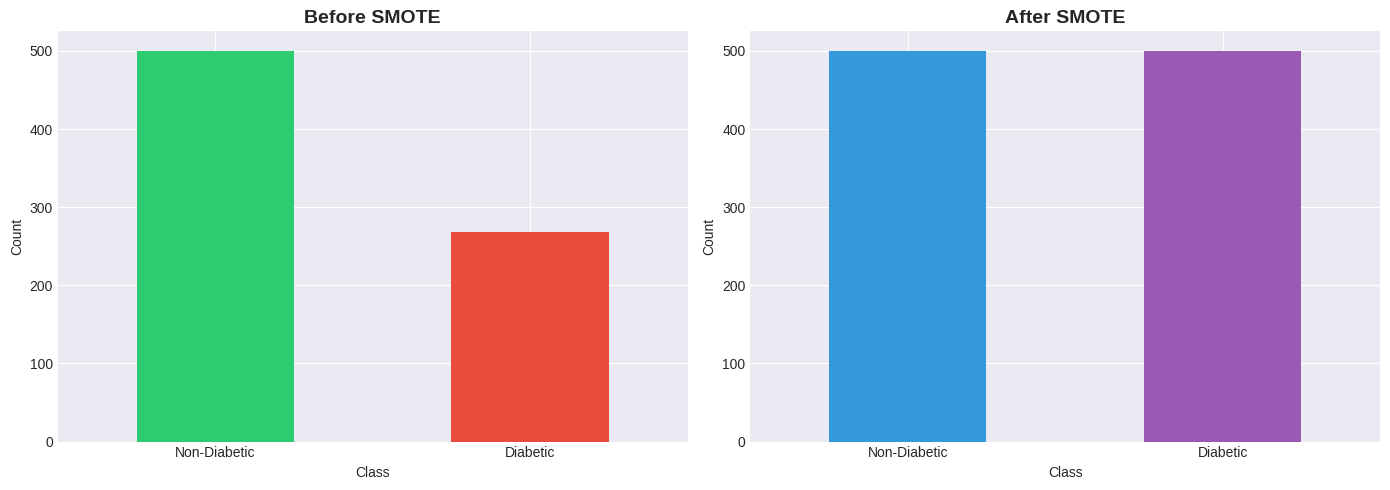

In [7]:
# ============================================================================
# 6. HANDLE CLASS IMBALANCE WITH SMOTE
# ============================================================================
print("\n[5] Applying SMOTE for Class Balancing...")
print(f"Before SMOTE - Class distribution:")
print(f"Class 0: {(y==0).sum()}, Class 1: {(y==1).sum()}")

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

print(f"\nAfter SMOTE - Class distribution:")
print(f"Class 0: {(y_balanced==0).sum()}, Class 1: {(y_balanced==1).sum()}")
print(f"Total samples: {len(X_balanced)}")

# Visualize before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pd.Series(y).value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-Diabetic', 'Diabetic'], rotation=0)

pd.Series(y_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['#3498db', '#9b59b6'])
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Non-Diabetic', 'Diabetic'], rotation=0)

plt.tight_layout()
plt.savefig('smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


[6] Applying Recursive Feature Elimination (RFE)...

Selected 6 features:
1. Pregnancies
2. Glucose
3. BloodPressure
4. Insulin
5. BMI
6. DiabetesPedigreeFunction

Feature Ranking:
                    Feature  Ranking  Selected
0               Pregnancies        1      True
1                   Glucose        1      True
2             BloodPressure        1      True
4                   Insulin        1      True
6  DiabetesPedigreeFunction        1      True
5                       BMI        1      True
7                       Age        2     False
3             SkinThickness        3     False


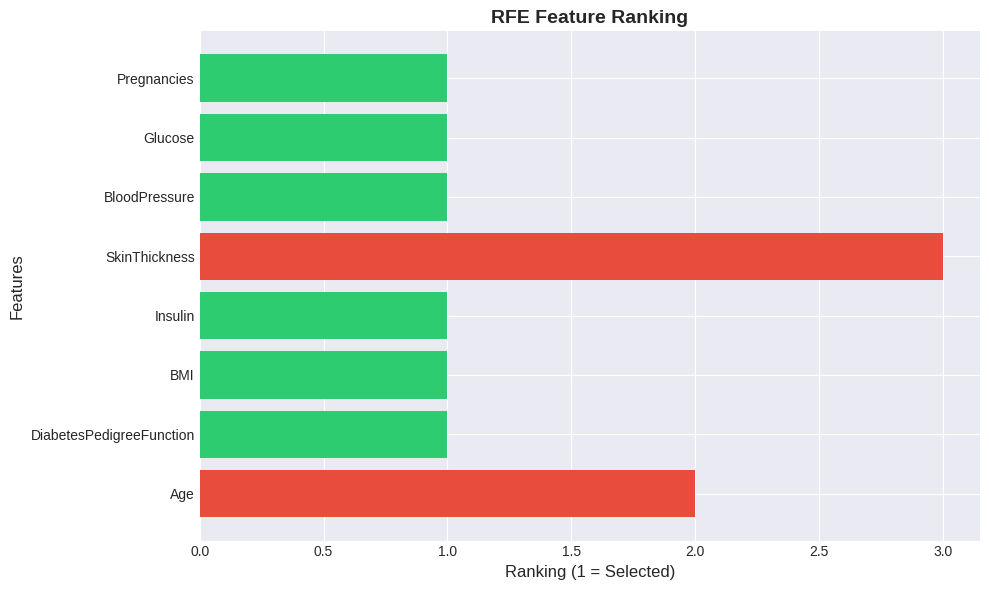

In [8]:
# ============================================================================
# 7. RECURSIVE FEATURE ELIMINATION (RFE)
# ============================================================================
print("\n[6] Applying Recursive Feature Elimination (RFE)...")

# Use Logistic Regression as estimator for RFE
estimator = LogisticRegression(max_iter=1000, random_state=42)

# Try different numbers of features
n_features_to_select = 6  # You can adjust this

rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select)
X_rfe = rfe.fit_transform(X_balanced, y_balanced)

# Get selected features
selected_features = X.columns[rfe.support_].tolist()
print(f"\nSelected {n_features_to_select} features:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")

# Feature ranking
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values('Ranking')

print(f"\nFeature Ranking:")
print(feature_ranking)

# Visualize feature importance
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if selected else '#e74c3c' for selected in rfe.support_]
plt.barh(X.columns, rfe.ranking_, color=colors)
plt.xlabel('Ranking (1 = Selected)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('RFE Feature Ranking', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('rfe_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# ============================================================================
# 8. MODEL TRAINING WITH 5-FOLD CROSS VALIDATION
# ============================================================================
print("\n[7] Training Models with 5-Fold Cross Validation...")

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

# Store results
results = []
cv_scores = {}

# 5-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n" + "="*80)
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Cross-validation scores
    accuracy_scores = cross_val_score(model, X_rfe, y_balanced, cv=skf, scoring='accuracy')
    precision_scores = cross_val_score(model, X_rfe, y_balanced, cv=skf, scoring='precision')
    recall_scores = cross_val_score(model, X_rfe, y_balanced, cv=skf, scoring='recall')
    f1_scores = cross_val_score(model, X_rfe, y_balanced, cv=skf, scoring='f1')
    roc_auc_scores = cross_val_score(model, X_rfe, y_balanced, cv=skf, scoring='roc_auc')

    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy_scores.mean(),
        'Accuracy_Std': accuracy_scores.std(),
        'Precision': precision_scores.mean(),
        'Precision_Std': precision_scores.std(),
        'Recall': recall_scores.mean(),
        'Recall_Std': recall_scores.std(),
        'F1-Score': f1_scores.mean(),
        'F1_Std': f1_scores.std(),
        'ROC-AUC': roc_auc_scores.mean(),
        'ROC_AUC_Std': roc_auc_scores.std()
    })

    cv_scores[name] = {
        'accuracy': accuracy_scores,
        'precision': precision_scores,
        'recall': recall_scores,
        'f1': f1_scores,
        'roc_auc': roc_auc_scores
    }

    print(f"  Accuracy: {accuracy_scores.mean():.4f} \u00b1 {accuracy_scores.std():.4f}")
    print(f"  Precision: {precision_scores.mean():.4f} \u00b1 {precision_scores.std():.4f}")
    print(f"  Recall: {recall_scores.mean():.4f} \u00b1 {recall_scores.std():.4f}")
    print(f"  F1-Score: {f1_scores.mean():.4f} \u00b1 {f1_scores.std():.4f}")
    print(f"  ROC-AUC: {roc_auc_scores.mean():.4f} \u00b1 {roc_auc_scores.std():.4f}")

print("\n" + "="*80)


[7] Training Models with 5-Fold Cross Validation...


Training Logistic Regression...
  Accuracy: 0.7480 ± 0.0112
  Precision: 0.7714 ± 0.0208
  Recall: 0.7060 ± 0.0102
  F1-Score: 0.7370 ± 0.0086
  ROC-AUC: 0.8455 ± 0.0183

Training Random Forest...
  Accuracy: 0.8050 ± 0.0281
  Precision: 0.7877 ± 0.0301
  Recall: 0.8360 ± 0.0301
  F1-Score: 0.8109 ± 0.0268
  ROC-AUC: 0.8891 ± 0.0166

Training Gradient Boosting...
  Accuracy: 0.7870 ± 0.0254
  Precision: 0.7750 ± 0.0290
  Recall: 0.8100 ± 0.0253
  F1-Score: 0.7919 ± 0.0236
  ROC-AUC: 0.8711 ± 0.0178

Training Support Vector Machine...
  Accuracy: 0.7760 ± 0.0252
  Precision: 0.7486 ± 0.0232
  Recall: 0.8320 ± 0.0431
  F1-Score: 0.7876 ± 0.0259
  ROC-AUC: 0.8495 ± 0.0177

Training Decision Tree...
  Accuracy: 0.7320 ± 0.0438
  Precision: 0.7396 ± 0.0566
  Recall: 0.7220 ± 0.0397
  F1-Score: 0.7297 ± 0.0402
  ROC-AUC: 0.7320 ± 0.0438

Training Naive Bayes...
  Accuracy: 0.7290 ± 0.0263
  Precision: 0.7636 ± 0.0301
  Recall: 0.6640 ± 0

In [10]:
# ============================================================================
# 9. RESULTS SUMMARY
# ============================================================================
print("\n[8] Results Summary...")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Recall', ascending=False)

print("\nPerformance Summary (Sorted by Recall):")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('model_performance_results.csv', index=False)
print("\nResults saved to 'model_performance_results.csv'")


[8] Results Summary...

Performance Summary (Sorted by Recall):
                 Model  Accuracy  Accuracy_Std  Precision  Precision_Std  Recall  Recall_Std  F1-Score   F1_Std  ROC-AUC  ROC_AUC_Std
         Random Forest     0.805      0.028107   0.787712       0.030051   0.836    0.030067  0.810906 0.026837  0.88914     0.016602
Support Vector Machine     0.776      0.025179   0.748636       0.023247   0.832    0.043081  0.787557 0.025884  0.84950     0.017685
     Gradient Boosting     0.787      0.025417   0.775041       0.029043   0.810    0.025298  0.791886 0.023608  0.87113     0.017798
         Decision Tree     0.732      0.043772   0.739562       0.056578   0.722    0.039699  0.729741 0.040217  0.73200     0.043772
   Logistic Regression     0.748      0.011225   0.771438       0.020796   0.706    0.010198  0.737032 0.008574  0.84546     0.018293
           Naive Bayes     0.729      0.026344   0.763589       0.030124   0.664    0.043174  0.709672 0.032150  0.82442     0.0288


[9] Visualizing Results...


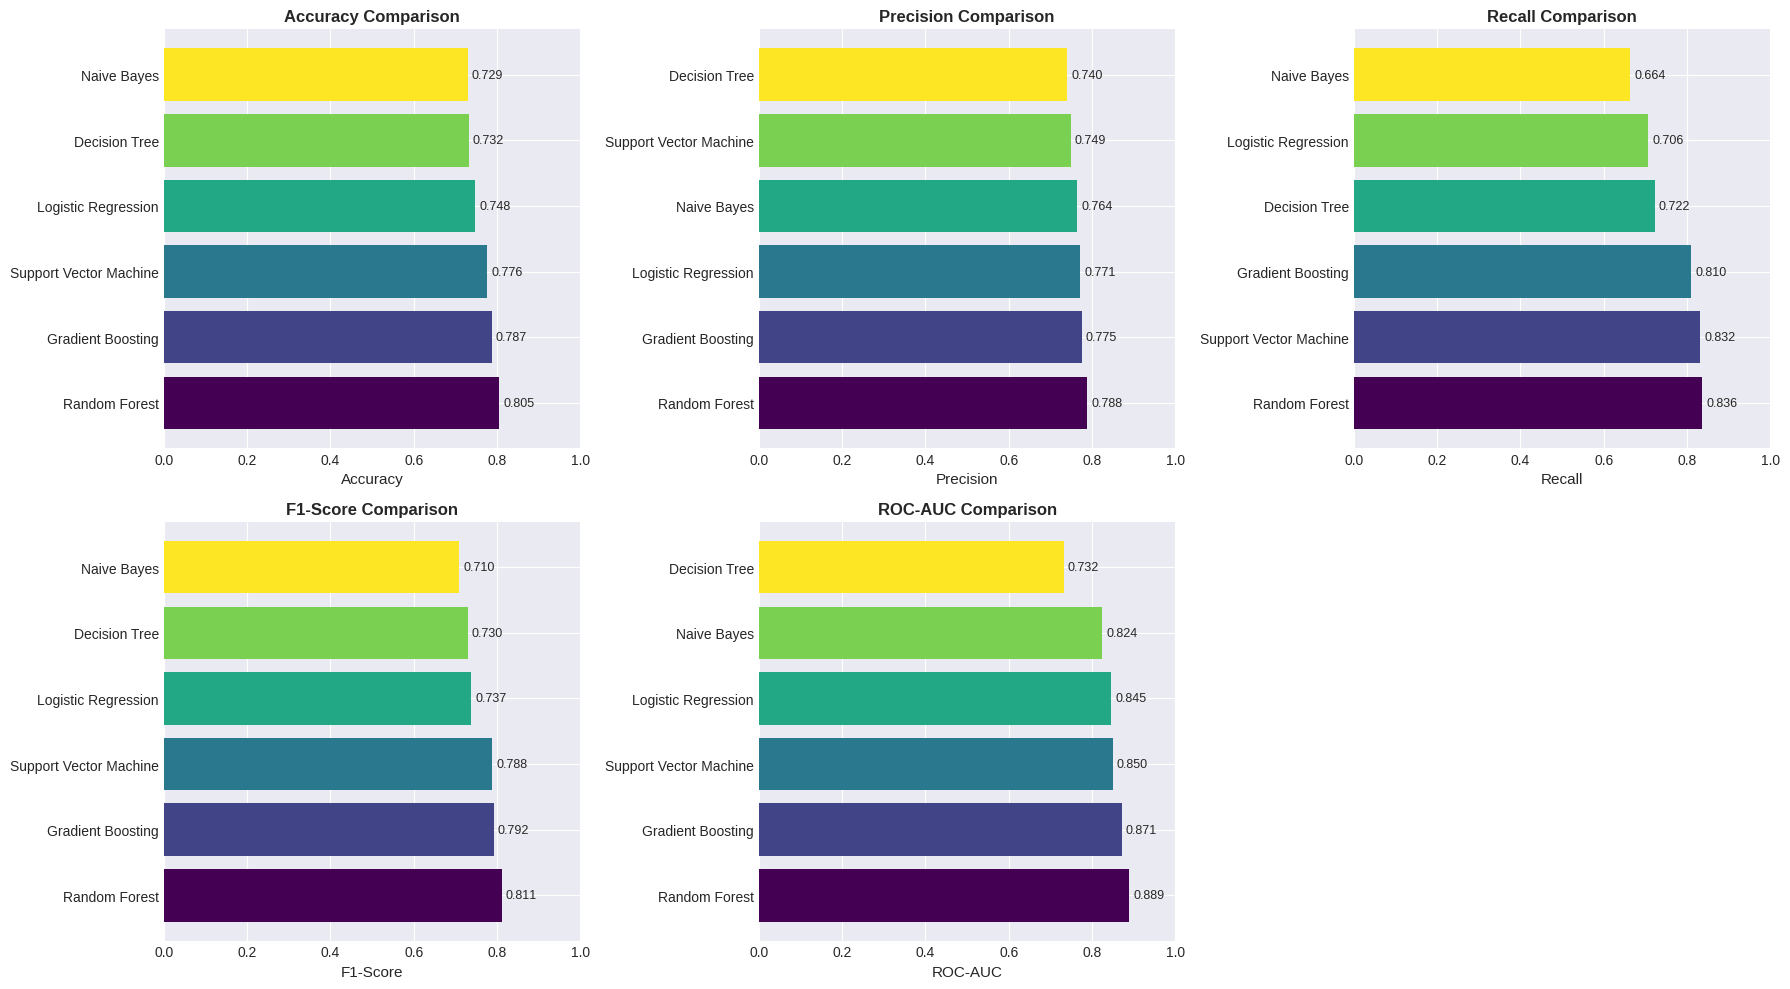

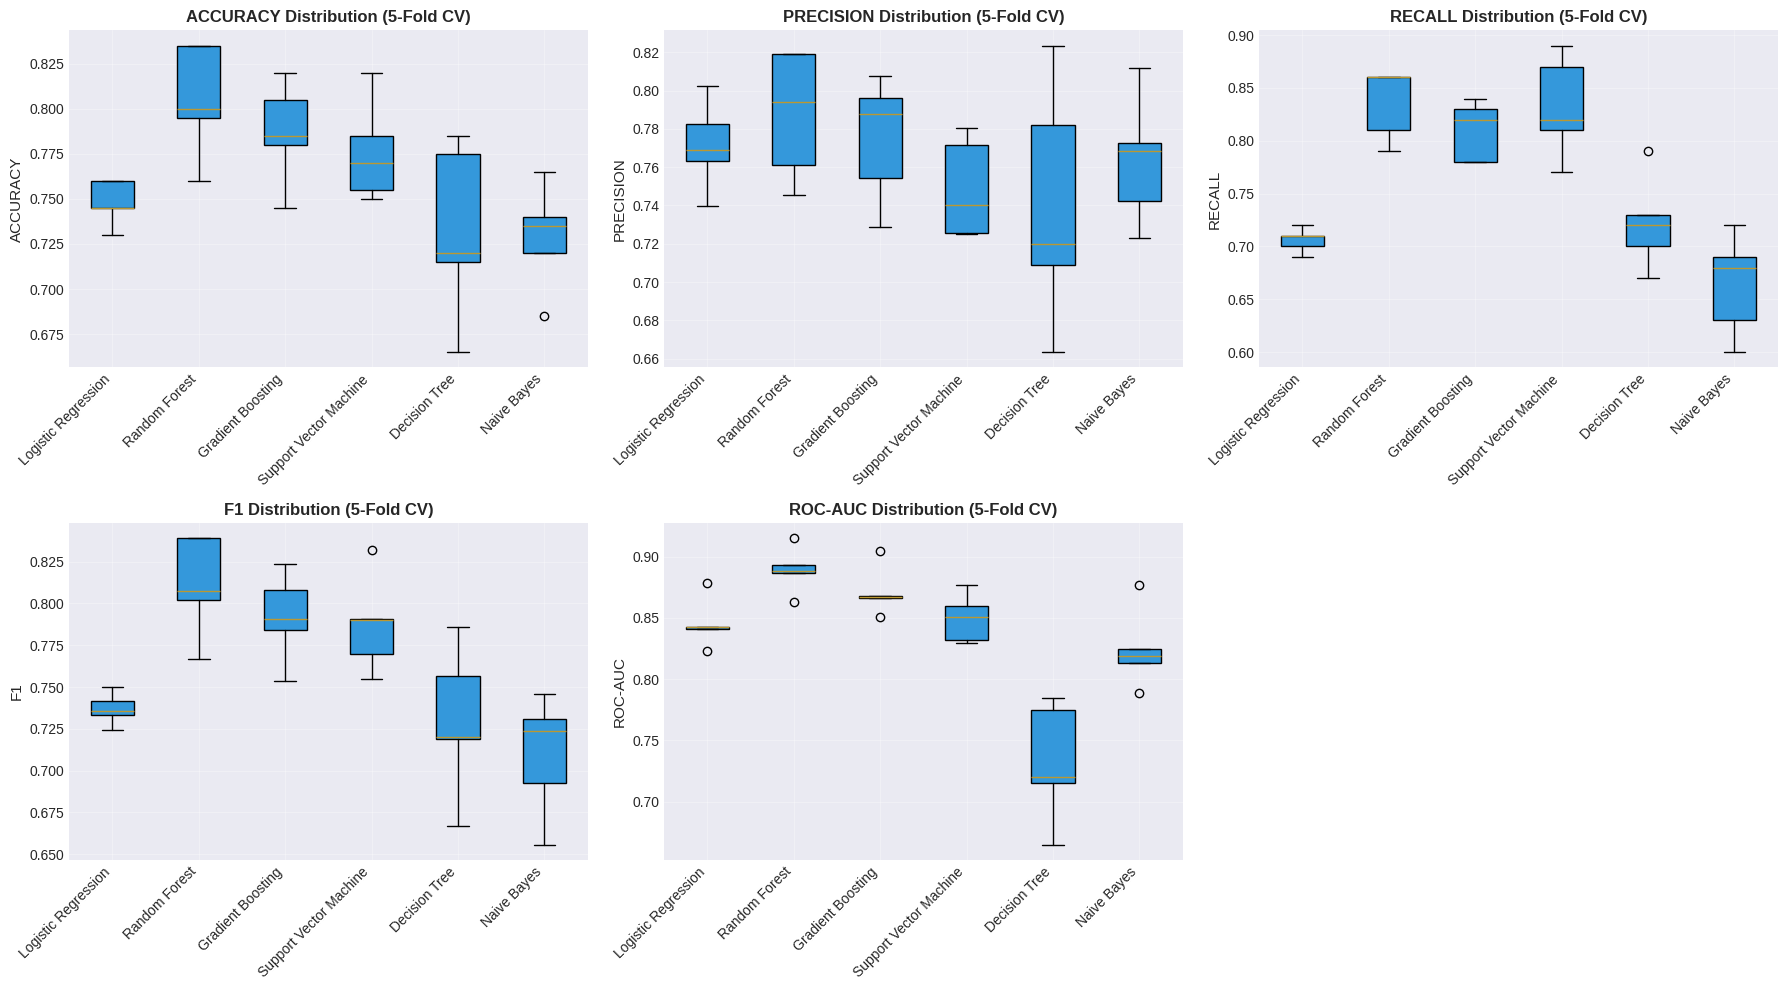

In [11]:
# ============================================================================
# 10. VISUALIZE RESULTS
# ============================================================================
print("\n[9] Visualizing Results...")

# Plot comparison of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    data = results_df.sort_values(metric, ascending=False)
    ax.barh(data['Model'], data[metric], color=plt.cm.viridis(np.linspace(0, 1, len(data))))
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1])

    # Add value labels
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Box plot for cross-validation scores
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, metric in enumerate(['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    ax = axes[idx]
    data_to_plot = [cv_scores[model][metric] for model in models.keys()]
    bp = ax.boxplot(data_to_plot, labels=models.keys(), patch_artist=True)

    # Color boxes
    for patch in bp['boxes']:
        patch.set_facecolor('#3498db')

    ax.set_ylabel(metric.upper().replace('_', '-'), fontsize=11)
    ax.set_title(f'{metric.upper().replace("_", "-")} Distribution (5-Fold CV)',
                 fontsize=12, fontweight='bold')
    ax.set_xticklabels(models.keys(), rotation=45, ha='right')
    ax.grid(True, alpha=0.3)

fig.delaxes(axes[5])
plt.tight_layout()
plt.savefig('cv_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


[10] Detailed Evaluation of Best Model...

Best Model (Highest Recall): Random Forest

Test Set Performance:
Accuracy: 0.8100
Precision: 0.8039
Recall: 0.8200
F1-Score: 0.8119
ROC-AUC: 0.8961

Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.82      0.80      0.81       100
    Diabetic       0.80      0.82      0.81       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



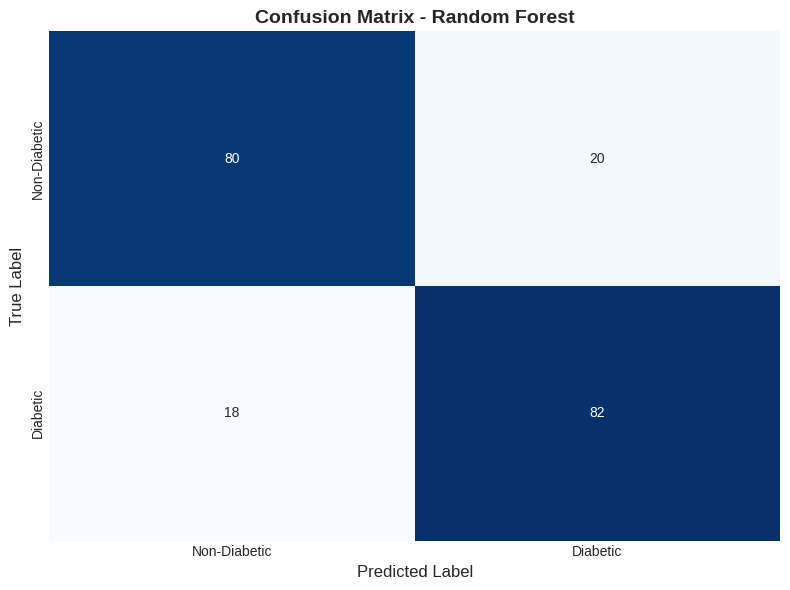

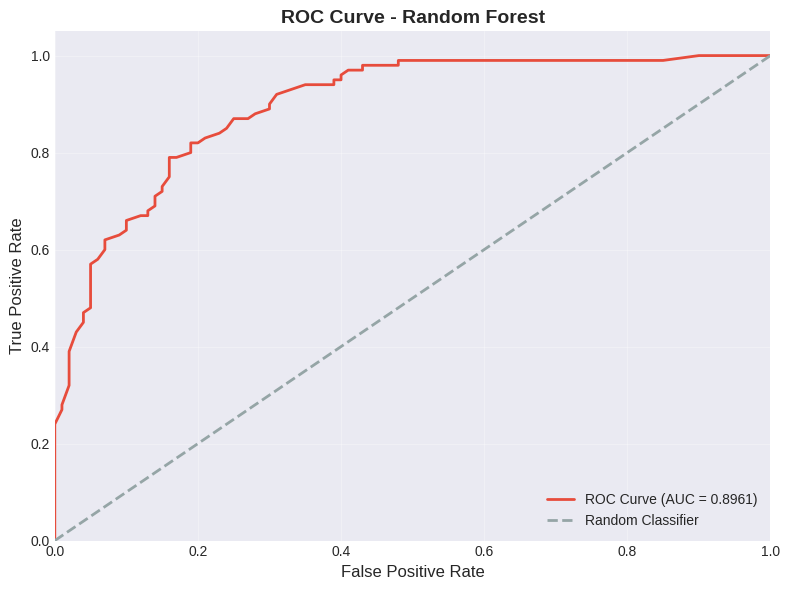

In [12]:
# ============================================================================
# 11. BEST MODEL EVALUATION
# ============================================================================
print("\n[10] Detailed Evaluation of Best Model...")

# Get best model based on Recall
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\nBest Model (Highest Recall): {best_model_name}")

# Split data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_rfe, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Train best model
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Diabetic', 'Diabetic']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#95a5a6', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# ============================================================================
# 12. FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\n\u2713 Dataset: {df.shape[0]} samples, {df.shape[1]-1} features")
print(f"\u2713 Class Distribution: {(y==0).sum()} Non-Diabetic, {(y==1).sum()} Diabetic")
print(f"\u2713 After SMOTE: {len(X_balanced)} balanced samples")
print(f"\u2713 Selected Features: {len(selected_features)} out of {len(X.columns)}")
print(f"\u2713 Best Model: {best_model_name}")
print(f"\u2713 Best Recall: {results_df.iloc[0]['Recall']:.4f}")
print(f"\u2713 Best F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

print("\n\ud83d\udcca Selected Features for Prediction:")
for i, feature in enumerate(selected_features, 1):
    print(f"   {i}. {feature}")

print("\n" + "="*80)
print("Analysis Complete! All visualizations have been saved.")
print("="*80)

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 104, in json_packer
    ).encode("utf8", errors="surrogateescape")
      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 451-452: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/zmq/eventloop/zmqstream.py", line 551, in _run_callback
    f = callback(*args, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 120, in _handle_event
    event_f()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py", line 848, in send
    to